# Histopathologic Cancer Detection using CNNs
Rafiq Premji - CSCA 5642

## Step 1: Descriptions

### Problem Description
The goal is to develop an algorithm to identify cancer in image patches extracted from pathology scans. It's a binary classification task where we need to determine if at least one pixel in a 32x32 region contains tumor tissue.

### Data Description
The dataset is a modified version of the PCam benchmark dataset with duplicates removed. The training data contains 220,025 images with provided binary labels, indicating if the center 32x32 region contains tumor tissue. The test data contains 57,458 unlabeled images. The images are 96x96 pixels, but we are only checking if the center 32x32 region contains a tumor.

Since the structure of the data is TIF images, the dimension is 96x96x3 which corresponds with width x height x color channels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2

## Step 2: Exploratory Data Analysis

In [21]:
# load data
base_path = 'week3_data/'
labels_df = pd.read_csv(base_path+'train_labels.csv')
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


number of training samples: 220025


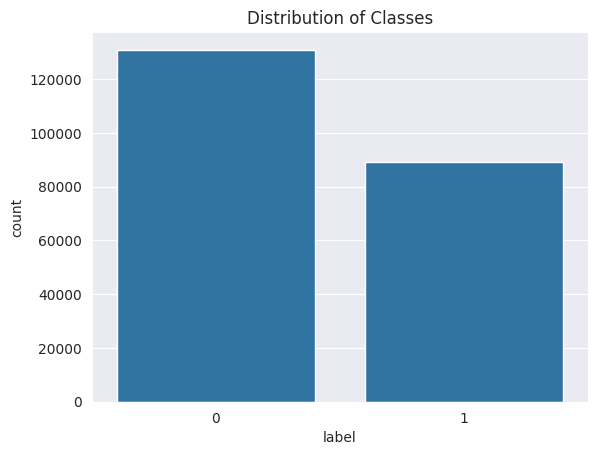

distribution:
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [22]:
print(f"number of training samples: {labels_df.shape[0]}")

# check class balance
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Classes')
plt.ylabel('count')
plt.show()

class_dist = labels_df['label'].value_counts(normalize=True)
print(f"distribution:\n{class_dist}")

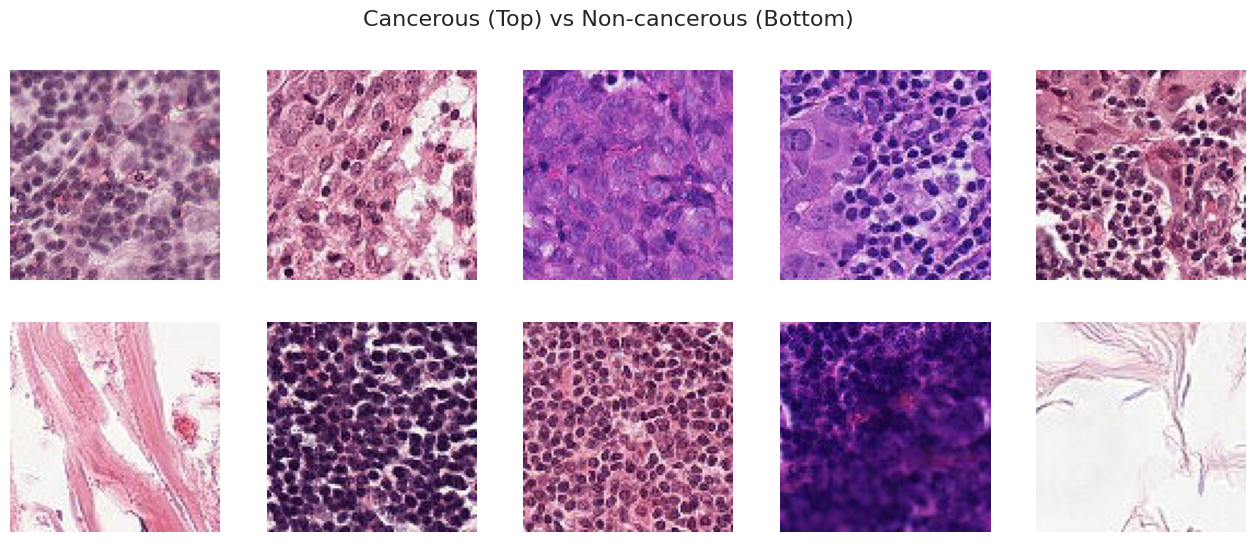

In [23]:
train_path = Path(base_path+'train')

# visualize positive/negative samples
positive_samples = labels_df[labels_df['label'] == 1].sample(5, random_state=42)
negative_samples = labels_df[labels_df['label'] == 0].sample(5, random_state=42)

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
fig.suptitle('Cancerous (Top) vs Non-cancerous (Bottom)', fontsize=16)

for i, idx in enumerate(positive_samples['id']):
    img_path = train_path / (idx + ".tif")
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0,i].imshow(img)
    axes[0,i].axis('off')

for i, idx in enumerate(negative_samples['id']):
    img_path = train_path / (idx + ".tif")
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1,i].imshow(img)
    axes[1,i].axis('off')

plt.show()

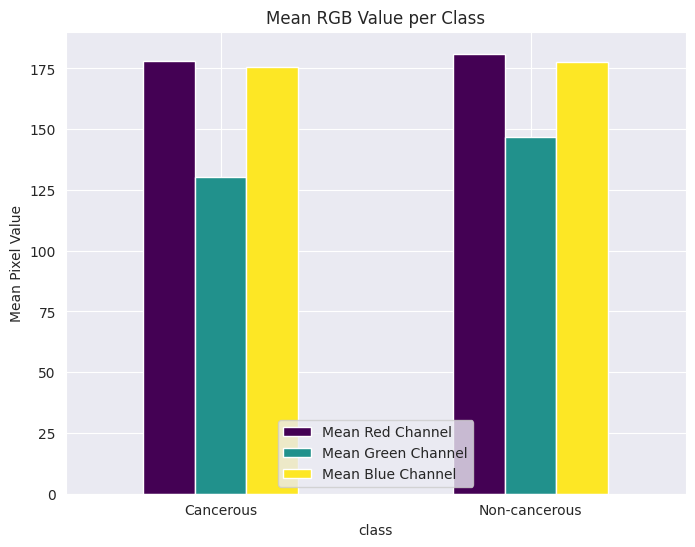

In [24]:
# visualize mean rgb values per class
def get_mean_rgb(images_path, image_ids):
    mean_r = []
    mean_g = []
    mean_b = []
    for idx in image_ids:
        img = cv2.imread(str(images_path / (idx + '.tif')))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mean_r.append(np.mean(img[:,:,0]))
        mean_g.append(np.mean(img[:,:,1]))
        mean_b.append(np.mean(img[:,:,2]))
    return np.mean(mean_r), np.mean(mean_g), np.mean(mean_b)

# sample 1000 images from each
sample_size = 1000
pos_samples = labels_df[labels_df['label']==1]['id'].sample(sample_size, random_state=42)
neg_samples = labels_df[labels_df['label']==0]['id'].sample(sample_size, random_state=42)

pos_mean = get_mean_rgb(train_path, pos_samples)
neg_mean = get_mean_rgb(train_path, neg_samples)

df_mean_rgb = pd.DataFrame({'class':['Cancerous', 'Non-cancerous'],
                            'Mean Red Channel':[pos_mean[0],neg_mean[0]],
                            'Mean Green Channel':[pos_mean[1],neg_mean[1]],
                            'Mean Blue Channel':[pos_mean[2],neg_mean[2]]})

fig = df_mean_rgb.set_index('class').plot(kind='bar', figsize=(8,6), colormap='viridis')
plt.title('Mean RGB Value per Class')
plt.ylabel('Mean Pixel Value')
plt.xticks(rotation=0)
plt.legend(loc='lower center')
plt.show()

There's a clear difference in intensity of green pixels between the two classes

In [25]:
# cleaning

# check for missing files
missing_files = []
for idx in labels_df['id']:
    img_path = train_path / (idx + ".tif")
    if not img_path.exists():
        missing_files.append(idx)
print(f"missing files in dataset: {len(missing_files)}")

# cast labels to string
labels_df['label'] = labels_df['label'].astype(str)

missing files in dataset: 0


## Plan of Analysis
Based on the EDA, my plan is:
- Since the data is well balanced, I won't correct for class imbalance.
- There are no concerns about missing files or duplicate images, so further cleaning isn't necessary.
- Since the images contain color and texture information (and because it's required for this assignment), I will use a CNN architecture which uses convolutional layers, pooling, and regularization.

## Step 3: Model Architecture

Convolutional Neural Networks are well-suited for this task because their architectures effectively capture spatial hierarchies by leveraging convolutional layers to detect edges, textures, etc. Recognizing complex visual patterns is essential for accurately identifying distinctions between healthy and cancerous cells.

I'm going to experiment with two different CNN architectures based on VGG and ResNet.

### Model 1: VGG-Based
This model will consist of three convolutional "blocks" with increasing filter amounts.
- Block 1: 32 filters, 3x3 kernel size, ReLU activation, 2x2 max-pooling layer
- Block 2: 64 filters, 3x3 kernel size, ReLU activation, 2x2 max-pooling layer
- Block 3: 128 filters, 3x3 kernel size, ReLU activation, 2x2 max-pooling layer
- Flattening layer
- Dense layer with 256 units and ReLU activation
- Dropout layer to reduce overfitting
- Final output layer with 1 binary unit and sigmoid activation

### Model 2: ResNet-Based
This model will have residual blocks with skip connections, which mitigate vanishing gradients and allow successful training of deeper networks.
- Initial convolutional layer: 7x7 kernel size, stride 2, 64 filters, ReLU activation
- MaxPooling layer: 3x3 kernel size, stride 2
- Residual Block 1:
  - Two 3x3 convolutional layers (64 filters each), stride 1
  - Skip (identity) connection added before ReLU activation
- Residual Block 2 (downsample):
  - First convolution: 3x3 kernel, 128 filters, stride 2
  - Second convolution: 3x3 kernel, 128 filters, stride 1
  - Skip connection with a 1x1 convolution (128 filters, stride 2) for dimension match
- Residual Block 3 (downsample):
  - First convolution: 3x3 kernel, 256 filters, stride 2
  - Second convolution: 3x3 kernel, 256 filters, stride 1
  - Skip connection with a 1x1 convolution (256 filters, stride 2) for dimension match
- Global Average Pooling to summarize features spatially
- Final Dense layer with 1 binary unit and sigmoid activation


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, GlobalAveragePooling2D, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

2025-05-19 23:11:34.237196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747717894.251059  186629 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747717894.255569  186629 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747717894.269075  186629 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747717894.269090  186629 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747717894.269091  186629 computation_placer.cc:177] computation placer alr

In [9]:
# VGG model
def build_vgg_model(input_shape, learning_rate, dropout_rate):
    vgg_model = Sequential([
        Input(shape=input_shape),

        # block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # flatten and dense Layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),

        # output layer
        Dense(1, activation='sigmoid')
    ])

    # compile
    vgg_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return vgg_model

# test instantiate
vgg_model = build_vgg_model((96, 96, 3), 1e-4, 0.5)
vgg_model.summary()

I0000 00:00:1747717896.052800  186629 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6855 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,006,113 (19.10 MB)

 Trainable params: 5,006,113 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ResNet model
def residual_block(input_tensor, filters, downsample=False):
    stride = 2 if downsample else 1

    # convolutional layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', activation='relu')(input_tensor)

    # convolutional layer with linear activation
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)

    # shortcut connection
    if downsample:
        input_tensor = Conv2D(filters, (1, 1), strides=2, padding='same')(input_tensor)

    # residual connection
    x = Add()([x, input_tensor])

    # post-addition activation
    x = tf.keras.layers.Activation('relu')(x)

    return x

def build_resnet_model(input_shape, learning_rate):
    inputs = Input(shape=input_shape)

    # initial convolutional and pooling
    x = Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    # blocks
    x = residual_block(x, filters=64, downsample=False)
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=256, downsample=True)

    # global average and output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    resnet_model = Model(inputs=inputs, outputs=outputs)

    # compile
    resnet_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return resnet_model

# test instantiate
resnet_model = build_resnet_model((96, 96, 3), 1e-4)
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 48, 48,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 24, 24,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 24, 24,    │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ conv2d_8[0][0],   │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 24, 24,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 12, 12,    │     73,856 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 12, 12,    │    147,584 │ conv2d_9[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 12, 12,    │      8,320 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 12, 12,    │          0 │ conv2d_10[0][0],  │
│                     │ 128)              │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 12, 12,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 6, 6, 256) │    295,168 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 6, 6, 256) │    590,080 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 6, 6, 256) │     33,024 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 6, 6, 256) │          0 │ conv2d_13[0][0],  │
│                     │                   │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 6, 6, 256) │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_2[0][

 Total params: 1,231,617 (4.70 MB)

 Trainable params: 1,231,617 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# make data generators for training
from sklearn.model_selection import train_test_split

labels_df['filename'] = labels_df['id'] + '.tif'

# Split into training and validation sets (80/20 split)
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df.label)

print('Number of training samples:', len(train_df))
print('Number of validation samples:', len(val_df))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    channel_shift_range=50
)

val_datagen = ImageDataGenerator(rescale=1./255)  # no augmentations for validation

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=base_path+'train/',
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    seed=42,
    validate_filenames=True,
    subset=None,
    interpolation='nearest',
    color_mode='rgb',
    save_format='tif'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=base_path+'train/',
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary',
    shuffle=False,
    seed=42,
    validate_filenames=True,
    subset=None,
    interpolation='nearest',
    color_mode='rgb',
    save_format='tif'
)

Number of training samples: 176020
Number of validation samples: 44005
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [12]:
# hyperparameter tuning for VGG model
# I'm only doing a few values in the interest of time because it takes around an hour for each run of 10 epocs on my computer.
# I tried to get this working in Google Colab with a faster GPU but wasn't able to in a reasonable amount of time.

learning_rates = [1e-4, 1e-5]
dropout_rates = [0.3, 0.5]

results_vgg = []
for lr in learning_rates:
    for dp_rate in dropout_rates:
        print(f"Training VGG-type model: lr={lr}, dropout={dp_rate}")

        # build model
        model = build_vgg_model(input_shape=(96, 96, 3), learning_rate=lr, dropout_rate=dp_rate)
        model.compile(Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

        # avoid overfitting
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=[es],
            verbose=2
        )

        # store final validation accuracy
        val_acc_final = history.history['val_accuracy'][-1]
        results_vgg.append({
            'learning_rate': lr,
            'dropout_rate': dp_rate,
            'val_accuracy': val_acc_final
        })

results_vgg_df = pd.DataFrame(results_vgg)
display(results_vgg_df)

Training VGG-type model: lr=0.0001, dropout=0.3


/home/rafiq/Code/csca5642-week3/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1747717900.258971  187780 service.cc:152] XLA service 0x7ff6b8003730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747717900.258984  187780 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1747717900.566787  187780 cuda_dnn.cc:529] Loaded cuDNN version 91001
I0000 00:00:1747717904.383580  187780 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 - 296s - 108ms/step - accuracy: 0.7878 - loss: 0.4581 - val_accuracy: 0.8041 - val_loss: 0.4578
Epoch 2/10
2751/2751 - 287s - 104ms/step - accuracy: 0.8384 - loss: 0.3691 - val_accuracy: 0.8250 - val_loss: 0.4075
Epoch 3/10
2751/2751 - 288s - 105ms/step - accuracy: 0.8565 - loss: 0.3322 - val_accuracy: 0.8509 - val_loss: 0.3510
Epoch 4/10
2751/2751 - 287s - 104ms/step - accuracy: 0.8737 - loss: 0.3004 - val_accuracy: 0.8261 - val_loss: 0.4412
Epoch 5/10
2751/2751 - 272s - 99ms/step - accuracy: 0.8868 - loss: 0.2750 - val_accuracy: 0.8854 - val_loss: 0.2849
Epoch 6/10
2751/2751 - 271s - 98ms/step - accuracy: 0.8965 - loss: 0.2552 - val_accuracy: 0.8411 - val_loss: 0.4208
Epoch 7/10
2751/2751 - 269s - 98ms/step - accuracy: 0.9047 - loss: 0.2392 - val_accuracy: 0.8385 - val_loss: 0.4260
Epoch 8/10
2751/2751 - 271s - 99ms/step - accuracy: 0.9110 - loss: 0.2265 - val_accuracy: 0.8500 - val_loss: 0.4061
Epoch 9/10
2751/2751 - 270s - 98ms/step - accuracy: 0.9164 - loss: 0.2141 - val

,learning_rate,dropout_rate,val_accuracy
0,0.00010,0.3,0.888626
1,0.00010,0.5,0.869651
2,0.00001,0.3,0.806249
3,0.00001,0.5,0.825088


In [13]:
# hyperparameter tuning for ResNet model
# ResNet doesn't use dropout so I'm only tuning the learning rate

learning_rates = [1e-4, 1e-5]

# store results
results_resnet = []
for lr in learning_rates:
    print(f"Training ResNet-type model: lr={lr}")

    # build model
    model = build_resnet_model(input_shape=(96, 96, 3), learning_rate=lr)
    model.compile(Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    # avoid overfitting
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[es],
        verbose=2
    )

    # store final validation accuracy
    val_acc_final = history.history['val_accuracy'][-1]
    results_resnet.append({
        'learning_rate': lr,
        'val_accuracy': val_acc_final
    })

results_resnet_df = pd.DataFrame(results_resnet)
display(results_resnet_df)

Training ResNet-type model: lr=0.0001
Epoch 1/10
2751/2751 - 281s - 102ms/step - accuracy: 0.7786 - loss: 0.4732 - val_accuracy: 0.7225 - val_loss: 0.5721
Epoch 2/10
2751/2751 - 275s - 100ms/step - accuracy: 0.8185 - loss: 0.4038 - val_accuracy: 0.7808 - val_loss: 0.4589
Epoch 3/10
2751/2751 - 273s - 99ms/step - accuracy: 0.8370 - loss: 0.3681 - val_accuracy: 0.7925 - val_loss: 0.4686
Epoch 4/10
2751/2751 - 272s - 99ms/step - accuracy: 0.8482 - loss: 0.3472 - val_accuracy: 0.8358 - val_loss: 0.3739
Epoch 5/10
2751/2751 - 271s - 98ms/step - accuracy: 0.8586 - loss: 0.3268 - val_accuracy: 0.8279 - val_loss: 0.4167
Epoch 6/10
2751/2751 - 272s - 99ms/step - accuracy: 0.8680 - loss: 0.3086 - val_accuracy: 0.8312 - val_loss: 0.3947
Epoch 7/10
2751/2751 - 274s - 99ms/step - accuracy: 0.8747 - loss: 0.2947 - val_accuracy: 0.7863 - val_loss: 0.5313
Epoch 8/10
2751/2751 - 272s - 99ms/step - accuracy: 0.8806 - loss: 0.2837 - val_accuracy: 0.8067 - val_loss: 0.4763
Epoch 9/10
2751/2751 - 274s - 10

,learning_rate,val_accuracy
0,0.00010,0.830656
1,0.00001,0.794955


## Step 4: Results and Analysis

In [26]:
# combine tuning results into one dataframe
results_vgg_df['model'] = 'VGG'
results_resnet_df['model'] = 'ResNet'
results_resnet_df['dropout_rate'] = 'N/A'  # ResNet had no dropout tuning
results_df = pd.concat([results_vgg_df, results_resnet_df])

display(results_df)

,learning_rate,dropout_rate,val_accuracy,model
0,0.00010,0.3,0.888626,VGG
1,0.00010,0.5,0.869651,VGG
2,0.00001,0.3,0.806249,VGG
3,0.00001,0.5,0.825088,VGG
0,0.00010,N/A,0.830656,ResNet
1,0.00001,N/A,0.794955,ResNet


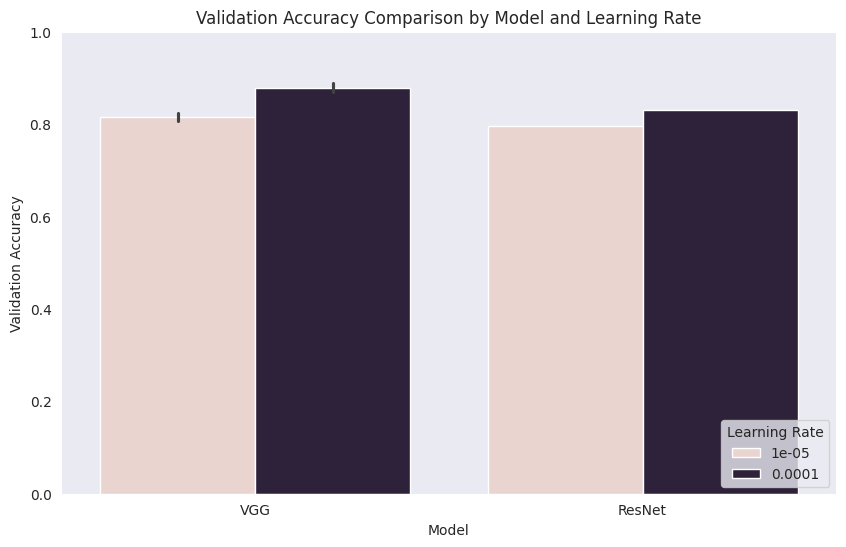

In [27]:
# graph accuracy of learning rates by model

plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='model', y='val_accuracy', hue='learning_rate')
plt.title('Validation Accuracy Comparison by Model and Learning Rate')
plt.ylabel('Validation Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Learning Rate', loc='lower right')
plt.show()

Based on my results, I will use the following hyperparameters:
- VGG: Learning Rate 1e-4, Dropout Rate: 30%
- ResNet: Learning Rate 1e-4

In [ ]:
# retrain the final models with optimal hyperparameters and more epochs
# this took a few more hours on my computer

optimal_vgg_model = build_vgg_model(input_shape=(96,96,3), learning_rate=1e-4, dropout_rate=0.3)
early_stop_vgg = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vgg = optimal_vgg_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop_vgg],
    verbose=2
)

optimal_resnet_model = build_resnet_model(input_shape=(96,96,3), learning_rate=1e-4)
early_stop_resnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_resnet = optimal_resnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop_resnet],
    verbose=2
)

Epoch 1/20


In [17]:
# now make a final set of validation predictions with the improved models
vgg_pred = optimal_vgg_model.predict(val_generator).ravel()
resnet_pred = optimal_resnet_model.predict(val_generator).ravel()

688/688 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step
688/688 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step


Validation ROC AUC scores:
VGG: 0.9705
ResNet: 0.9537


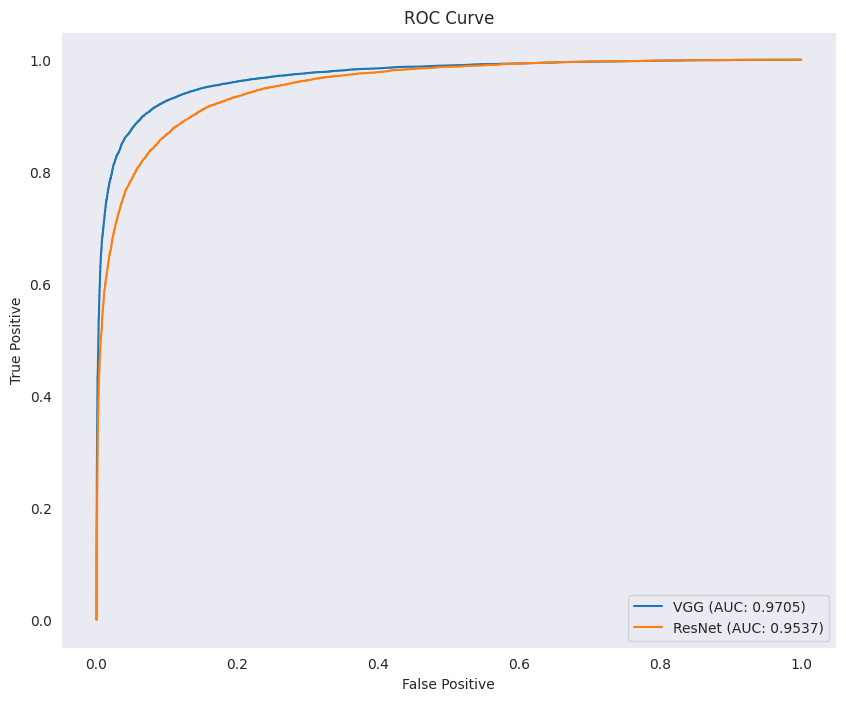

In [18]:
# graph the ROC Curve of the final validation

from sklearn.metrics import roc_auc_score, roc_curve

y_true = val_generator.classes

vgg_auc = roc_auc_score(y_true, vgg_pred)
resnet_auc = roc_auc_score(y_true, resnet_pred)

print(f"Validation ROC AUC scores:\nVGG: {vgg_auc:.4f}\nResNet: {resnet_auc:.4f}")

fpr_vgg, tpr_vgg, _ = roc_curve(y_true, vgg_pred)
fpr_resnet, tpr_resnet, _ = roc_curve(y_true, resnet_pred)

plt.figure(figsize=(10,8))
plt.plot(fpr_vgg, tpr_vgg, label=f"VGG (AUC: {vgg_auc:.4f})")
plt.plot(fpr_resnet, tpr_resnet, label=f"ResNet (AUC: {resnet_auc:.4f})")
plt.title('ROC Curve')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.grid()
plt.show()

### Analysis of Results and Troubleshooting:
- I'm pleased with the results for running relatively few epochs total on my local GPU (3080), achieving over 90% accuracies with both models.
- It's interesting that the ResNet model takes longer to train even though it has around 1/4 the params of the VGG model.
- Both models performed better with a slightly higher learning rate and the VGG model with a lower dropout rate, but because of time/resource limitations I was only able to try a few combinations of hyperparameters.
- VGG outperformed ResNet in the ROC AUC curve, but only slightly with both models performing excellently.
- Models were sensitive to learning rate choices. Deterioration in accuracy was noticeable when learning rates were tiny (1e-5), as training became overly slow.
- Short training epochs (10) possibly limited ability to converge fully, potentially affecting the quality of results.

### Hyperparameter Optimization:
For parameter tuning, a grid search approach was used.
- Searched on learning rates [1e-4, 1e-5] and dropout rates [0.3, 0.5] (for VGG only).
- Setup early stopping based on validation loss prevented overfitting and saved computation, but due to small epoch amounts this was never triggered.

In [20]:
# submit both model predictions to kaggle

test_path = Path(base_path+'test')
test_files = list(test_path.glob('*.tif'))
test_ids = [f.stem for f in test_files]

test_df = pd.DataFrame({'id': test_ids, 'filename': [f.name for f in test_files]})

# rescale images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=str(test_path),
    x_col='filename',
    y_col=None,
    target_size=(96, 96),
    color_mode='rgb',
    class_mode=None,
    batch_size=64,
    shuffle=False
)

# make vgg/resnet predictions
vgg_preds_test = optimal_vgg_model.predict(test_generator, verbose=1).ravel()
resnet_preds_test = optimal_resnet_model.predict(test_generator, verbose=1).ravel()

# save for kaggle
submission_vgg = pd.DataFrame({'id': test_ids, 'label': vgg_preds_test})
submission_resnet = pd.DataFrame({'id': test_ids, 'label': resnet_preds_test})

submission_vgg.to_csv('submission_vgg.csv', index=False)
submission_resnet.to_csv('submission_resnet.csv', index=False)

Found 57458 validated image filenames.
  4/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step

/home/rafiq/Code/csca5642-week3/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step


## Step 5: Final Results and Conclusion

After submitting both models' predictions to Kaggle, my results where:
- VGG: 0.9436 (public score), 0.9200 (private score)
- ResNet: 0.9446 (public score), 0.8861 (private score)

Both models exceeded my expectations and performed virtually identical on the public score. It's interesting that they diverged in the private scores and I'm not sure if it's an anomoly or a result of the ResNet model being less converged than the VGG model.

### Future Improvements
If I were to try this challenge again I would:
- Build simpler models with fewer parameters and try to train them for a larger number of epochs (at least 50-100).
- Get it working in a cloud environment with Google Colab or vast.ai so I am not constrained by time.
- Use my increased resources to perform a larger hyperparameter search (more params, more values).
- Experiment with transfer learning from pre-trained ImageNet architectures.